# ChiSquare test/distribution for general fits:

This Python program/notebook illustrates the use of ChiSquare as a goodness-of-fit measure, how this distribution comes about, and that it actually works, here with three different examples! The first example is the linear fit, while the two others are more complicated (oscillatory graph fit and exponential fit of a histogram). However, they have one thing in common, namely the number of degrees of freedom!

## References:
* Barlow: Chapter 6
* Cowan: Chapter 2.7, Chapter 7
* Bevington: Chapter 6

## Author(s), contact(s), and dates:
* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   16th of November 2023

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

***
Make sure you've read the relevant references and that you understand not only what
the ChiSquare is, but also that it follows the ChiSquare distribution, and that the
probability of obtaining such a ChiSquare or worse can be calculated from it.

The program generates a certain number of datasets in three different ways, from
which the Chi2 of the fit is recorded.
***

## Program settings:

In [3]:
Minuit.print_level = 0      # Don't print the fit result (many fits to do!)
save_plots = False

In [4]:
r = np.random                         # Random generator
r.seed(42)                            # Set a random seed (but a fixed one - more on that later.)

## Generate and fit LINEAR data:

In [5]:
Nexp = 1000
NpointsLin = 17

In [6]:
alpha0 = 3.6
alpha1 = 0.3
sigmay = 0.4

In [7]:
array_Chi2_Lin = np.zeros(Nexp)
array_Prob_Lin = np.zeros(Nexp)

In [8]:
# Loop over number of experiments to generate data and subsequent Chi2 values:
for iexp in range( Nexp ) : 

    # Generate points:
    xLin = np.arange(NpointsLin)+1
    exLin = np.zeros_like(xLin)
    yLin = alpha0 + alpha1 * xLin + r.normal(0, sigmay, NpointsLin)
    eyLin = sigmay*np.ones_like(xLin)

    def fit_function_Lin(x, alpha0, alpha1):
        return alpha0 + alpha1*x
    
    chi2_object = Chi2Regression(fit_function_Lin, xLin, yLin, eyLin)
    chi2_object.errordef = 1.0       # Chi2 definition (for Minuit)
    minuitLin = Minuit(chi2_object, alpha0=1, alpha1=1)  
    minuitLin.migrad();  # perform the actual fit

    Chi2Lin = minuitLin.fval # the chi2 value
    NvarLin = 2                      # Number of variables (alpha0 and alpha1)
    NdofLin = NpointsLin - NvarLin   # Number of degrees of freedom
    ProbLin =  stats.chi2.sf(Chi2Lin, NdofLin) # The chi2 probability given N_DOF degrees of freedom
    
    array_Chi2_Lin[iexp] = Chi2Lin
    array_Prob_Lin[iexp] = ProbLin

In order to inspect the fits, we plot the last one produced:

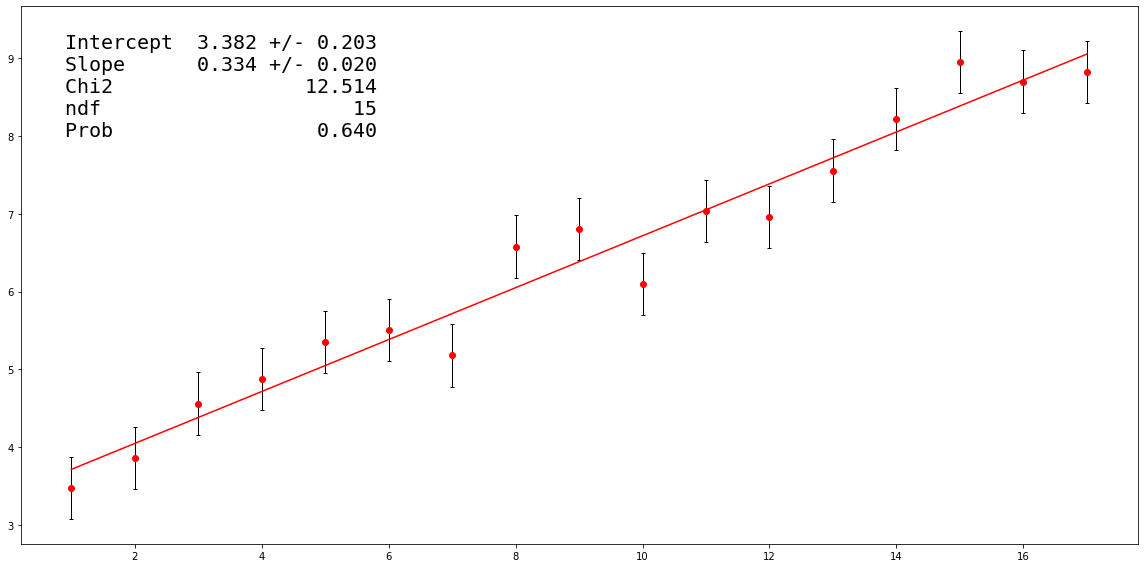

In [9]:
figLin, axLin = plt.subplots(figsize=(16, 8))
axLin.errorbar(xLin, yLin, eyLin, fmt='ro', ecolor='k', elinewidth=1, capsize=2, capthick=1)
axLin.plot(xLin, fit_function_Lin(xLin, *minuitLin.values[:]), '-r')

d = {'Intercept':[minuitLin.values['alpha0'], minuitLin.errors['alpha0']],
     'Slope':    [minuitLin.values['alpha1'], minuitLin.errors['alpha1']],
     'Chi2':     Chi2Lin,
     'ndf':      NdofLin,
     'Prob':     ProbLin,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.04, 0.95, text, axLin, fontsize=20)
figLin.tight_layout()

In [10]:
if (save_plots) : 
    figLin.savefig("Chi2Dist_LinearFit.pdf")

## Generate and fit OSCILLATING data:

In [11]:
NpointsOsc = 19
mean  = 1.6
amp   = 3.3
omega = 0.7
phase = 0.3
sigmay = 0.5

In [12]:
# Again we record the resulting Chi2 values and probabilities:
array_Chi2_Osc = np.zeros(Nexp)
array_Prob_Osc = np.zeros(Nexp)

In [13]:
# Loop over number of experiments to generate data and subsequent Chi2 values:
for iexp in range( Nexp ) : 

    # Generate points:
    xOsc = np.arange(NpointsOsc)+1
    exOsc = np.zeros_like(xLin)
    yOsc = mean + amp*np.cos(omega*xOsc + phase) + r.normal(0, sigmay, NpointsOsc)
    eyOsc = sigmay*np.ones_like(xOsc)

    # Fit points:
    def fit_function_Osc(x, mean, amp, omega, phase):
        return mean + amp*np.cos(omega*x + phase)
    
    chi2_object = Chi2Regression(fit_function_Osc, xOsc, yOsc, eyOsc)
    chi2_object.errordef = 1.0       # Chi2 definition (for Minuit)
    minuitOsc = Minuit(chi2_object, mean=mean, amp=amp, omega=omega, phase=phase)  
    minuitOsc.migrad();             # Perform the actual fit

    Chi2Osc = minuitOsc.fval        # Get the chi2 value
    NvarOsc = 4                     # Number of variables (mean, amp, omega, phase)
    NdofOsc = NpointsOsc - NvarOsc  # Number of degrees of freedom    
    ProbOsc =  stats.chi2.sf(Chi2Osc, NdofOsc) # The chi2 probability given N degrees of freedom, Ndof
    
    array_Chi2_Osc[iexp] = Chi2Osc
    array_Prob_Osc[iexp] = ProbOsc

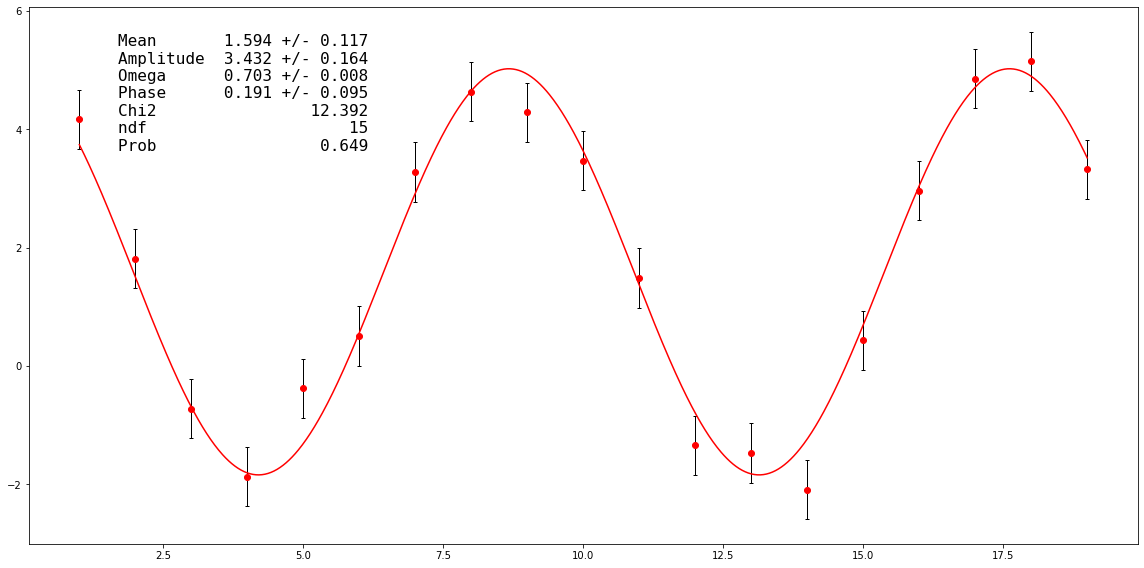

In [14]:
figOsc, axOsc = plt.subplots(figsize=(16, 8))
axOsc.errorbar(xOsc, yOsc, eyOsc, fmt='ro', ecolor='k', elinewidth=1, capsize=2, capthick=1)
xaxis = np.linspace(min(xOsc), max(xOsc), 1000)
axOsc.plot(xaxis, fit_function_Osc(xaxis, *minuitOsc.values[:]), '-r')

d = {'Mean':     [minuitOsc.values['mean'], minuitOsc.errors['mean']],
     'Amplitude':[minuitOsc.values['amp'], minuitOsc.errors['amp']],
     'Omega':    [minuitOsc.values['omega'], minuitOsc.errors['omega']],
     'Phase':    [minuitOsc.values['phase'], minuitOsc.errors['phase']],
     'Chi2':     Chi2Osc,
     'ndf':      NdofOsc,
     'Prob':     ProbOsc,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.08, 0.95, text, axOsc, fontsize=16)
figOsc.tight_layout()

In [15]:
if (save_plots) : 
    figOsc.savefig("Chi2Dist_OscillationFit.pdf")

## Generate and fit EXPONENTIAL binned data:

In [16]:
NpointsExp = 1000   # Put this number of points (exponentially distributed) in each histogram.
NbinsExp = 17       # Decide on the number of bins (for a reason!)

In [17]:
tau = 3.14           # I'm just picking a random lifetime...

In [18]:
array_Chi2_Exp = np.zeros(Nexp)
array_Prob_Exp = np.zeros(Nexp)

In [19]:
# Define an exponential fit function, which includes a normalisation:
def fit_function_Exp(x, tau, N) :
    return N / tau * np.exp(- x / tau)

In [20]:
# Loop over number of experiments to generate data and subsequent Chi2 values:
for iexp in range( Nexp ) : 
    
    dataExp = r.exponential(tau, NpointsExp)

    yExp, xExp_edges = np.histogram(dataExp, bins=NbinsExp, range=(0, NbinsExp))
    xExp = (xExp_edges[1:] + xExp_edges[:-1])/2
    syExp = np.sqrt(yExp)
    
    chi2_object = Chi2Regression(fit_function_Exp, xExp[yExp>0], yExp[yExp>0], syExp[yExp>0])
    chi2_object.errordef = 1.0       # Chi2 definition (for Minuit)
    minuitExp = Minuit(chi2_object, tau = tau, N=NpointsExp)  
    minuitExp.migrad();  # perform the actual fit

    Chi2Exp = minuitExp.fval
    NvarExp = 2                    # Number of variables (N and tau)
    NdofExp = NbinsExp - NvarExp   # Number of degrees of freedom
    ProbExp =  stats.chi2.sf(Chi2Exp, NdofExp) # The chi2 probability given N_DOF degrees of freedom
    
    array_Chi2_Exp[iexp] = Chi2Exp
    array_Prob_Exp[iexp] = ProbExp

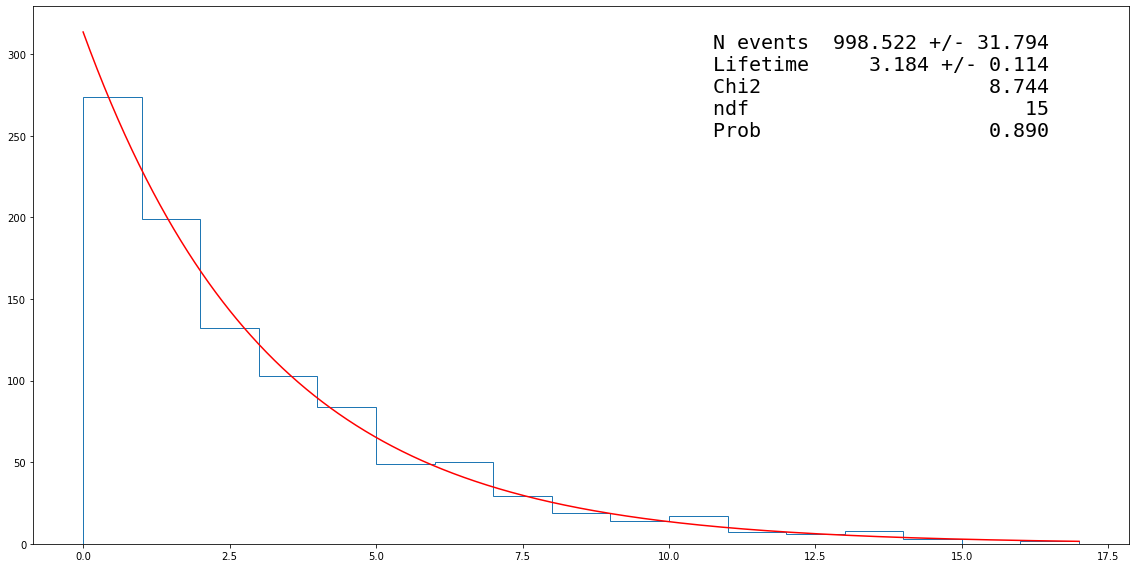

In [21]:
figExp, axExp = plt.subplots(figsize=(16, 8))
axExp.hist(dataExp, NbinsExp, range=(0, NbinsExp), histtype='step')
x_axis = np.linspace(0, NbinsExp, 1000)
axExp.plot(x_axis, fit_function_Exp(x_axis, *minuitExp.values[:]), '-r') 

d = {'N events': [minuitExp.values['N'], minuitExp.errors['N']],
     'Lifetime': [minuitExp.values['tau'], minuitExp.errors['tau']],
     'Chi2':     Chi2Exp,
     'ndf':      NdofExp,
     'Prob':     ProbExp,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.62, 0.95, text, axExp, fontsize=20)
figExp.tight_layout()

In [22]:
if (save_plots) : 
    figExp.savefig("Chi2Dist_ExponentialFit.pdf")

The above histogram does not show us the uncertainty used in each bin, which the $\chi^2$ needs for its calculation. We have discussed what error to use, and will surely be doing so more in the course, but below is code that gives a plot showing points and errors instead of a "bare" histogram. 

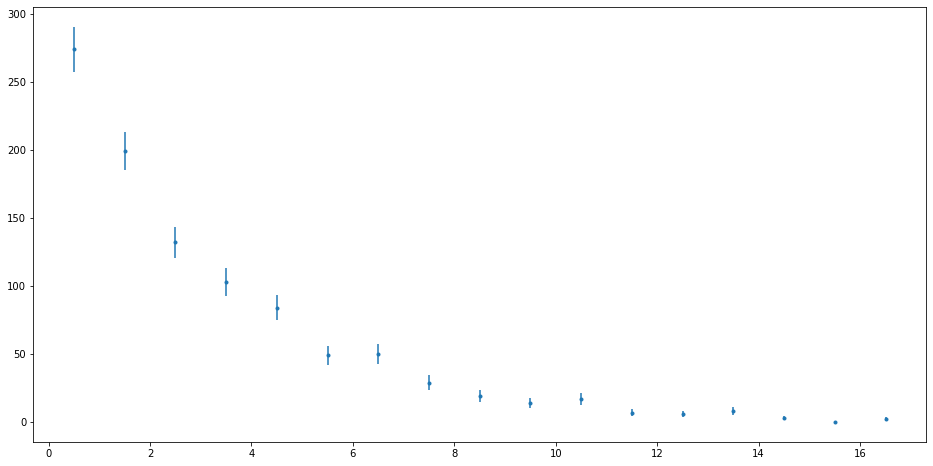

In [23]:
# Calculating points and errors:
y, bin_edges = np.histogram(dataExp, bins=NbinsExp, range=(0, NbinsExp))
x = 0.5*(bin_edges[:-1] + bin_edges[1:])
sy = np.sqrt(y)                             # Note: Ask yourself (here on in question 4 below) where these errors come from?

# Plotting the result of the above!
fig, ax = plt.subplots(figsize=(16,8))
hist1 = ax.errorbar(x, y, sy, fmt='.', label='Exponential distribution')

# Plot the function we fitted on top? That is a simple exercise for you!

# Considering repeated experiments/fits and resulting $\chi^2$ distributions:

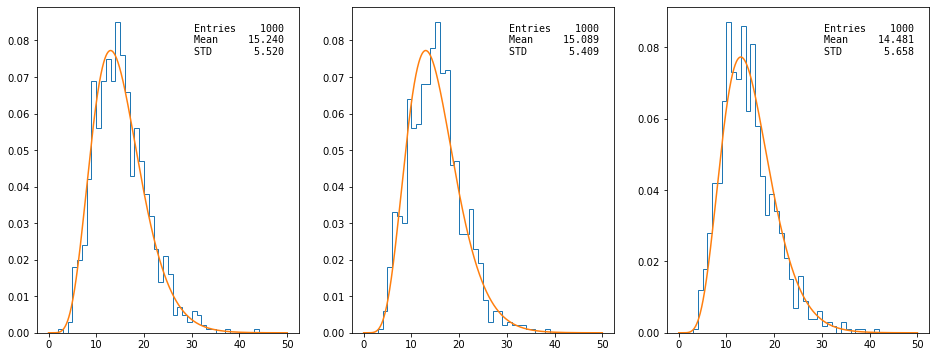

In [24]:
# If there have been more than one experiment, then make another white canvas:
if (Nexp > 1) :
    
    xaxis = np.linspace(0, 50, 1000)
    yaxis = stats.chi2.pdf(xaxis, 15)   # This is the Chi2 distribution with 15 DOF.
    
    array_Chi2 = [array_Chi2_Lin, array_Chi2_Osc, array_Chi2_Exp]

    fig2, ax2 = plt.subplots(ncols=3, figsize=(16, 6))
    for i in range(3):
        ax2[i].hist(array_Chi2[i], 50, range=(0, 50), histtype='step', density=True)    # Plot normalised!
        ax2[i].plot(xaxis, yaxis)
    
        # Here, we "just" put in quick remarks (note the "code"-like way of defining format. Do you understand it?):
        string  = f"Entries {len(array_Chi2[i]):7d}\n"
        string += f"Mean {array_Chi2[i].mean():10.3f}\n"
        string += f"STD {array_Chi2[i].std(ddof=1):11.3f}"
        ax2[i].text(0.6, 0.95, string, family='monospace', transform=ax2[i].transAxes, fontsize=10, verticalalignment='top')
        
    if (save_plots) : 
        fig2.savefig("Chi2Dist_SeveralCases.pdf")

# Questions:
 1. Why have I chosen the three examples to have 17 points, 19 points and 17 bins?
    Hint: What is the number of degrees of freedom in each of the three cases?

 2. In the example of the linear fit, what number of points lies outside +-1 sigma?
    Is that a reasonable number?

 3. In the oscillatory case, try to drop the part were you set the initial parameters
    or simply set them to zero, and see how well the fit goes, when it does not
    have good starting values. How often does it get a good fit result?

 4. In the exponential fit, where do the uncertainties come from? And is the fit
    reasonable?
    

### Advanced questions:
 5. Why does the last of the three Chi2 distributions not fit quite?
    Try to change the number of generated points to 100 instead of 1000,
    and/or change the lifetime to tau=2.1. Does this increase the mismatch
    of the Chi2 distribution. Does that give you a hint why?
    

# Learning points:

This exercise simply gives more ChiSquare fitting illustrations, yet with the same number of degrees of freedom (Ndof) in the fit. From this exercise you should simply get the knowledge of how to run a ChiSquare fit in different situations/cases, calculate Ndof, and be able to extract the p-value.